# Matching Pursuit

from LJ slides. Aftermeeting

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from skimage import draw
from scipy import signal
from PIL import Image
import pywt
import pywt.data

In [36]:
def fun_conv(A,B):
    conv = signal.fftconvolve(A,B,mode='same')
    return conv

def fun_auto(A):
    auto = signal.fftconvolve(A,np.flip(A),mode='same')
    return auto

## Part 1: y = h·Ψ·a where h is random normal and Ψ is Id

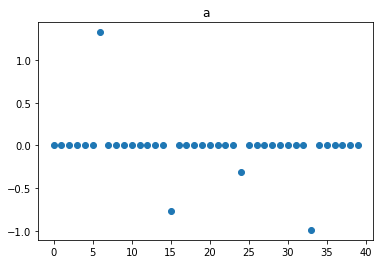

In [37]:
#defining vector a
np.random.seed(24)
a_values = np.random.normal(0, 1, 4)
d = 40
a_real = np.zeros((d,1))
for a_val in range(len(a_values)):
    a_real[6+9*a_val,0] = a_values[a_val]

plt.plot(range(d),a_real[:,0],'o')
plt.title('a')
plt.show()

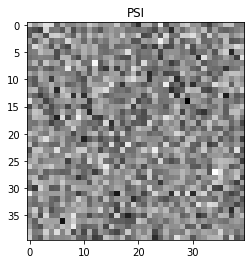

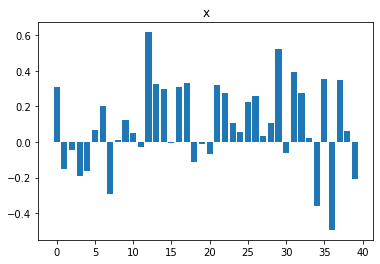

[ 0.30881923 -0.15311261 -0.04681248 -0.18939609 -0.16532238  0.06909447
  0.20230588 -0.29435192  0.01027378  0.12078677  0.05159494 -0.03069995
  0.6160982   0.32408187  0.29840123 -0.00299394  0.30844961  0.33203539
 -0.11313671 -0.00971094 -0.06729069  0.32011491  0.27734552  0.10609748
  0.05585069  0.22565259  0.26011422  0.0313209   0.1091595   0.52080373
 -0.06438531  0.39516427  0.27706921  0.02278341 -0.35929929  0.35594445
 -0.49353754  0.34674172  0.05963408 -0.21005626]


In [38]:
#PSI: I want to be a Normal random distribution
np.random.seed(0)
N = d
PSI = np.random.randn(N,d) #Not randn bbut rand
# PSI -= np.amin(PSI)
# PSI /= np.amax(PSI)/2
PSI -= PSI.mean()

#Normalization?
# for j in range(d):
#     PSI[:,j] /= np.sum(PSI[:,j])   #This one? L1

# for j in range(d):
#     PSI[:,j] /= np.max(PSI[:,j])  #This one? Max

# for j in range(d):
#     PSI[:,j] -= PSI[:,j].mean()
#     PSI[:,j] /= PSI[:,j].std()
#     PSI[:,j] -= np.amin(PSI[:,j])
#     PSI[:,j] /= np.amax(PSI[:,j])

for j in range(d):
    PSI[:,j] /= np.linalg.norm(PSI[:,j])   #This one? L2

# PSI -= PSI.mean()

plt.imshow(PSI, cmap='gray')
plt.title('PSI')
plt.show()

#x
x = PSI@a_real

plt.bar(range(N),x[:,0])
plt.title('x')
plt.show()
print(x[:,0])

r - [x-PSI*a_(k+1)] = 0.0, ans: 0.0
<r_(k+1),PSI_i*> = 0.0, ans: 2.185751579730777e-16
r - [x-PSI*a_(k+1)] = 0.0, ans: 4.163336342344337e-17
<r_(k+1),PSI_i*> = 0.0, ans: -6.245004513516506e-17
r - [x-PSI*a_(k+1)] = 0.0, ans: 4.163336342344337e-17
<r_(k+1),PSI_i*> = 0.0, ans: -2.688821387764051e-17
r - [x-PSI*a_(k+1)] = 0.0, ans: 2.463307335887066e-16
<r_(k+1),PSI_i*> = 0.0, ans: 1.3877787807814457e-17


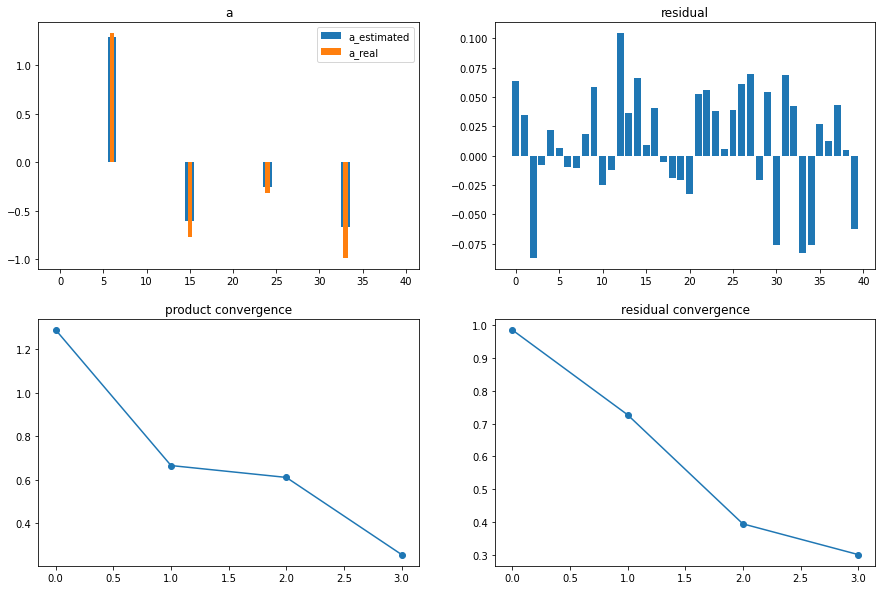

In [39]:
r = x
a = a_real*0
k = 0
s = 4
plotting_product = np.array([])
plotting_residue = np.array([])

while (k<s):
    #atom selection
    arg2max_array = np.array([[]])

    # arg2max(PSI.T@r)
    for i in range(d):
        arg2max = abs(PSI[:,i:i+1].T@r)
        arg2max_array = np.append(arg2max_array,arg2max,axis=1)

    i_star, = np.where(arg2max_array[0,:]==np.amax(arg2max_array[0,:]))
    i_star = int(i_star)

    #coef. update
    e = a*0
    e[i_star,0]=1
    a = a + (PSI[:,i_star:i_star+1].T@r)*e

    #residual update
    r = r - (PSI[:,i_star:i_star+1].T@r)*PSI[:,i_star:i_star+1]
    r2 = x - PSI@a
    print('r - [x-PSI*a_(k+1)] = 0.0, ans:',np.sum(r-r2))
    print('<r_(k+1),PSI_i*> = 0.0, ans:',float(r.T@PSI[:,i_star:i_star+1]))
    

    #plotting elements
    plotting_product = np.append(plotting_product,arg2max_array[0,i_star])
    plotting_residue = np.append(plotting_residue,np.linalg.norm(r))

    k += 1
    
    # print(np.amax(arg2max_array[0,:]))
    # plt.bar(range(d),arg2max_array[0,:])
    # plt.show()
    # plt.bar(range(d),a[:,0])
    # plt.show()

fig = plt.figure(figsize=(15,10))

fig.add_subplot(2, 2, 1)
plt.bar(range(d), a[:,0], width=1, label='a_estimated')
plt.bar(range(d), a_real[:,0], width=0.5, label='a_real')
plt.title('a')
plt.legend()

fig.add_subplot(2, 2, 2)
plt.bar(range(N),r[:,0])
plt.title('residual')

fig.add_subplot(2, 2, 3)
plt.plot(plotting_product,'o-')
plt.title('product convergence')

fig.add_subplot(2, 2, 4)
plt.plot(plotting_residue,'o-')
plt.title('residual convergence')
plt.show()

## OMP

[6.]
[ 6. 33.]
[ 6. 33. 15.]
[ 6. 33. 15. 24.]


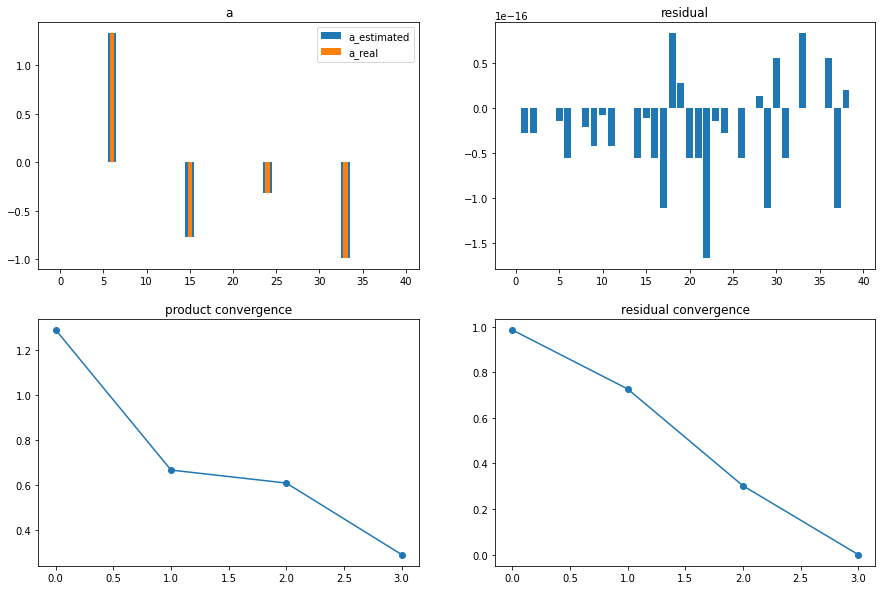

In [40]:
r = x
a = a_real*0
k = 0
s = 4
S = np.array([])
plotting_product = np.array([])
plotting_residue = np.array([])
PSIS = np.empty((N, 0), float)

while (k<s):
    #atom selection
    arg2max_array = np.array([[]])
    for i in range(d):
        arg2max = abs(PSI[:,i:i+1].T@r)
        arg2max_array = np.append(arg2max_array,arg2max,axis=1)

    i_star, = np.where(arg2max_array[0,:]==np.amax(arg2max_array[0,:]))
    i_star = int(i_star)

    #support update
    S = np.append(S,i_star)

    # #coef. update
    # arg2min_array = np.array([[]])
    # for ai in range(d):
    #     arg2min = 0.5*np.linalg.norm(x-PSI@ai)**2
    #     arg2min_array = np.append(arg2min_array,arg2min,axis=1)

    # numerical shortcut
    PSIS = np.append(PSIS, PSI[:,i_star:i_star+1], axis=1)
    aS = np.linalg.inv(PSIS.T@PSIS)@PSIS.T@x

    a = a_real*0
    for index in range(len(S)):
        ind2a = int(S[index])
        a[ind2a] = aS[index]
    print(S)

    #residual update
    r  = x - PSIS@aS
    
    #plotting elements
    plotting_product = np.append(plotting_product,arg2max_array[0,i_star])
    plotting_residue = np.append(plotting_residue,np.linalg.norm(r))

    k += 1
    
    # print(np.amax(arg2max_array[0,:]))
    # plt.bar(range(d),arg2max_array[0,:])
    # plt.show()
    # plt.bar(range(d),a[:,0])
    # plt.show()

fig = plt.figure(figsize=(15,10))

fig.add_subplot(2, 2, 1)
plt.bar(range(d), a[:,0], width=1, label='a_estimated')
plt.bar(range(d), a_real[:,0], width=0.5, label='a_real')
plt.title('a')
plt.legend()

fig.add_subplot(2, 2, 2)
plt.bar(range(N),r[:,0])
plt.title('residual')

fig.add_subplot(2, 2, 3)
plt.plot(plotting_product,'o-')
plt.title('product convergence')

fig.add_subplot(2, 2, 4)
plt.plot(plotting_residue,'o-')
plt.title('residual convergence')

plt.show()